# Importing the Modules

In [2]:
import numpy as np
np.random.seed(0)
from tensorflow.random import set_seed
set_seed(0)

import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Loading Data

The "actual" file contains all 72 patients in the study and the labels.

In [3]:
actual_df = pd.read_csv('gene-expression/actual.csv')
actual_df.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [4]:
actual_df['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [5]:
actual_df.shape

(72, 2)

Recode label to numeric.

In [6]:
y = actual_df.replace({'ALL':0, 'AML':1})
y = y.set_index('patient')
labels = ['ALL', 'AML']

Loading training and testing datasets.

In [7]:
train_df = pd.read_csv('../input/gene-expression/data_set_ALL_AML_train.csv')
test_df = pd.read_csv('../input/gene-expression/data_set_ALL_AML_independent.csv')

In [8]:
print("Shape of Training Data: ", train_df.shape)
print("Shape of Testing Data: ", test_df.shape)

Shape of Training Data:  (7129, 78)
Shape of Testing Data:  (7129, 70)


In [9]:
train_df.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


The 7129 gene descriptions are provided as the rows and the values for each patient as the columns. This will clearly require some tidying up.

We can remove "call" columns from training and testing dataframes.

In [10]:
train_to_keep=[col for col in train_df.columns if "call" not in col]
test_to_keep=[col for col in test_df.columns if "call" not in col]

X_train = train_df[train_to_keep]
X_test = test_df[test_to_keep]

Now we can simply transpose both training and testing dataframes so that genes become columns(features) and patients become rows.

In [11]:
X_train = X_train.T
X_test = X_test.T

The first 2 rows are duplicated so we can remove 'Gene Description' and set 'Gene Accession Number' as the column headers.

In [12]:
X_train.columns = X_train.iloc[1]
X_test.columns = X_test.iloc[1]

X_train = X_train.drop(['Gene Description', 'Gene Accession Number'])
X_test = X_test.drop(['Gene Description', 'Gene Accession Number'])

Neither the training and testing row indexes are not in numeric order, so it's important that we reorder these, so that the labels will line up with the corresponding data.

In [13]:
X_train.index = X_train.index.astype(int)
X_train.sort_index(inplace=True)

X_test.index = X_test.index.astype(int)
X_test.sort_index(inplace=True)

In the end, our data looks like this:

In [14]:
print("Shape of Training data:\t", X_train.shape)
print("Shape of Testing Data:\t", X_test.shape)

Shape of Training data:	 (38, 7129)
Shape of Testing Data:	 (34, 7129)


In [15]:
X_train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


Now let's split the target labels into training and testing targets.

In [16]:
y_train = y['cancer'][:38]
y_test = y['cancer'][38:]

## Standardizing Features

Note that the test set must use identical scaling to the training set.

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

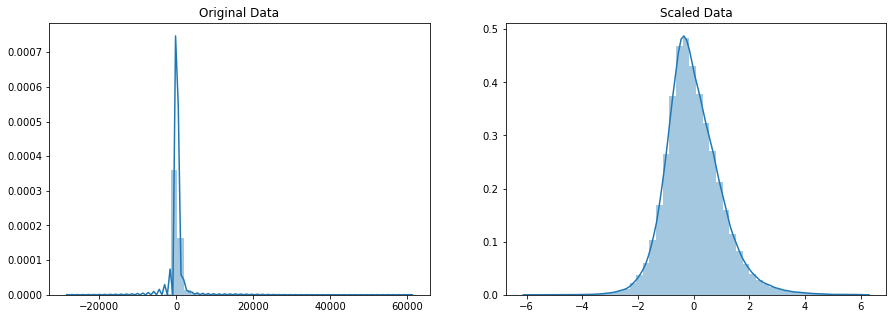

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.distplot(np.concatenate(X_train.values), ax=ax[0]).set_title('Original Data')
sns.distplot(np.concatenate(X_train_scaled), ax=ax[1]).set_title('Scaled Data')
plt.tight_layout
plt.show()

## Dimentionality reduction(PCA)

You need to apply the same PCA on training and testing sets.

In [19]:
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(X_train_pca.shape)
print(X_test_pca.shape)

(38, 32)
(34, 32)


95% of variance is explained by 32 principal components. We can't plot something in 32 dimensions, so let's just see what the PCA looks like when we just pick the top three compoments.

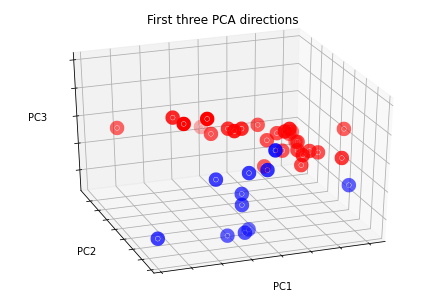

In [20]:
pca3 = PCA(n_components = 3).fit_transform(X_train_scaled)
colors = np.where(y_train==0, 'red', 'blue')
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c=colors, cmap=plt.cm.Paired,linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])
plt.show()

# Neural Network

In [21]:
NN_model = f model(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model

In [22]:
NN_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy']
)
def genetic_model(classes, name, input_shape, block_layers_num, weight_decay):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    for i in range(block_layers_num):
        x = ResidualBlock(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(8, 8), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name=name)
    return model

In [27]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=1000,
    min_delta=0.005,
    restore_best_weights=True,
)

In [29]:
train_history = NN_model.fit(genetic_model,
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    batch_size = 8,
    epochs = 500,
    callbacks=[early_stopping]
)

Epoch 1/500
5/5 [==============================] - 0s 12ms/step - loss: 1.4082e-04 - binary_accuracy: 1.0000 - val_loss: 0.4739 - val_binary_accuracy: 0.8824
Epoch 2/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3964e-04 - binary_accuracy: 1.0000 - val_loss: 0.4736 - val_binary_accuracy: 0.8824
Epoch 3/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3863e-04 - binary_accuracy: 1.0000 - val_loss: 0.4733 - val_binary_accuracy: 0.8824
Epoch 4/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3758e-04 - binary_accuracy: 1.0000 - val_loss: 0.4730 - val_binary_accuracy: 0.8824
Epoch 5/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3645e-04 - binary_accuracy: 1.0000 - val_loss: 0.4727 - val_binary_accuracy: 0.8824
Epoch 6/500
5/5 [==============================] - 0s 6ms/step - loss: 1.3540e-04 - binary_accuracy: 1.0000 - val_loss: 0.4724 - val_binary_accuracy: 0.8824
Epoch 7/500
5/5 [==============================] - 0s 6ms

In [30]:
pred = NN_model.predict_classes(X_test_pca)
print('Neural Network accuracy: ', round(accuracy_score(y_test, pred), 3))

Neural Network accuracy:  0.9449


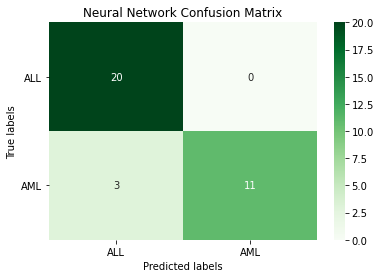

In [31]:
cm_nn = confusion_matrix(y_test, pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);